In [1]:
#import numpy as np
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.stats import gaussian_kde

#import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

from search_no_gpjax import generate_true_function
#from scipy.spatial import ConvexHull

import gpjax as gpx
from jax import grad, jit
import jaxkern as jk
import optax as ox
from jaxutils import Dataset

/home/dcai/miniconda3/envs/apm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU being used
print(jax.default_backend())
jax.devices()

gpu


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

# Original code

In [3]:
"""
This module provides the ConvexHull class.
"""

import itertools
import numpy as np
from typing import List, Sized, Union
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull as ConvexHullSciPy
from scipy.spatial import QhullError

class ConvexHullMod:
    """This class provides functionality for extracting the convex hull
    of the (free) energy of mixing. It is based on the `convex hull
    calculator in SciPy
    <http://docs.scipy.org/doc/scipy-dev/reference/\
generated/scipy.spatial.ConvexHull.html>`_.
    Parameters
    ----------
    concentrations : list(float) or list(list(float))
        concentrations for each structure listed as ``[[c1, c2], [c1, c2],
        ...]``; for binaries, in which case there is only one independent
        concentration, the format ``[c1, c2, c3, ...]`` works as well.
    energies : list(float)
        energy (or energy of mixing) for each structure
    Attributes
    ----------
    concentrations : np.ndarray
        concentrations of the `N` structures on the convex hull
    energies : np.ndarray
        energies of the `N` structures on the convex hull
    dimensions : int
        number of independent concentrations needed to specify a point in
        concentration space (1 for binaries, 2 for ternaries etc.)
    structures : list(int)
        indices of structures that constitute the convex hull (indices are
        defined by the order of their concentrations and energies are fed when
        initializing the ConvexHull object)
    Examples
    --------
    A `ConvexHull` object is easily initialized by providing lists of
    concentrations and energies::
        >>> data = {'concentration': [0,    0.2,  0.2,  0.3,  0.4,  0.5,  0.8,  1.0],
        ...         'mixing_energy': [0.1, -0.2, -0.1, -0.2,  0.2, -0.4, -0.2, -0.1]}
        >>> hull = ConvexHull(data['concentration'], data['mixing_energy'])
    Now one can for example access the points along the convex hull directly::
        >>> for c, e in zip(hull.concentrations, hull.energies):
        ...     print(c, e)
        0.0 0.1
        0.2 -0.2
        0.5 -0.4
        1.0 -0.1
    or plot the convex hull along with the original data using e.g., matplotlib::
        >>> import matplotlib.pyplot as plt
        >>> plt.scatter(data['concentration'], data['mixing_energy'], color='darkred')
        >>> plt.plot(hull.concentrations, hull.energies)
        >>> plt.show(block=False)
    It is also possible to extract structures at or close to the convex hull::
        >>> low_energy_structures = hull.extract_low_energy_structures(
        ...     data['concentration'], data['mixing_energy'],
        ...     energy_tolerance=0.005)
    A complete example can be found in the :ref:`basic tutorial
    <tutorial_enumerate_structures>`.
    """

    def __init__(self,
                 concentrations: Union[List[float], List[List[float]]],
                 energies: List[float]) -> None:
        assert len(concentrations) == len(energies)
        # Prepare data in format suitable for SciPy-ConvexHull
        concentrations = np.array(concentrations)
        energies = np.array(energies)
        points = np.column_stack((concentrations, energies))
        self.dimensions = len(points[0]) - 1

        # Construct convex hull
        hull = ConvexHullSciPy(points, qhull_options='Qs')

        # Collect convex hull points in handy arrays
        concentrations = []  # type: ignore
        energies = []  # type: ignore
        
        for vertex in hull.vertices:
            if self.dimensions == 1:
                concentrations.append(points[vertex][0])
            else:
                concentrations.append(points[vertex][0:-1])
            energies.append(points[vertex][-1])
        
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        structures = hull.vertices
        # If there is just one independent concentration, we'd better sort
        # according to it
        if self.dimensions == 1:
            ces = list(zip(*sorted(zip(concentrations, energies, structures))))
            self.concentrations = np.array(ces[0])
            self.energies = np.array(ces[1])
            self.structures = np.array(ces[2])
        else:
            self.concentrations = concentrations
            self.energies = energies
            self.structures = structures

        # Remove points that are above the "pure components plane"
        self._remove_points_above_tie_plane()

    def _remove_points_above_tie_plane(self, tol: float = 1e-3) -> None:
        """
        Remove all points on the convex hull that correspond to maximum rather
        than minimum energy.
        Parameters
        ----------
        tol
            Tolerance for what energy constitutes a lower one.
        """

        # Identify the "complex concentration hull", i.e. the extremal
        # concentrations. In the simplest case, these should simply be the
        # pure components.
        if self.dimensions == 1:
            # Then the ConvexHullScipy function doesn't work, so we just pick
            # the indices of the lowest and highest concentrations.
            vertices = []
            vertices.append(np.argmin(self.concentrations))
            vertices.append(np.argmax(self.concentrations))
            vertices = np.array(vertices)
        else:
            concentration_hull = ConvexHullSciPy(self.concentrations,qhull_options='Qs')
            vertices = concentration_hull.vertices

        # Remove all points of the convex energy hull that have an energy that
        # is higher than what would be gotten with pure components at the same
        # concentration. These points are mathematically on the convex hull,
        # but in the physically uninteresting upper part, i.e. they maximize
        # rather than minimize energy.
        to_delete = []
        for i, concentration in enumerate(self.concentrations):
            # The points on the convex concentration hull should always be
            # included, so skip them.
            if i in vertices:
                continue

            # The energy obtained as a linear combination of concentrations on
            # the convex hull is the "z coordinate" of the position on a
            # (hyper)plane in the (number of independent concentrations +
            # 1)-dimensional (N-D) space. This plane is spanned by N points.
            # If there are more vertices on the convex hull, we need to loop
            # over all combinations of N vertices.
            for plane in itertools.combinations(vertices,
                                                min(len(vertices),
                                                    self.dimensions + 1)):
                # Calculate energy that would be gotten with pure components
                # with ascribed concentration.
                energy_pure = griddata(self.concentrations[np.array(plane)],
                                       self.energies[np.array(plane)],
                                       concentration,
                                       method='linear')

                # Prepare to delete if the energy was lowered. `griddata` gives
                # NaN if the concentration is outside the triangle formed by
                # the three vertices. The result of the below comparison is
                # then False, which is what we want.
                if energy_pure < self.energies[i] - tol:
                    to_delete.append(i)
                    break

        # Finally remove all points
        self.concentrations = np.delete(self.concentrations, to_delete, 0)
        self.energies = np.delete(self.energies, to_delete, 0)
        self.structures = list(np.delete(self.structures, to_delete, 0))

    def get_energy_at_convex_hull(self, target_concentrations:
                                  Union[List[float],
                                        List[List[float]]]) -> np.ndarray:
        """Returns the energy of the convex hull at specified concentrations.
        If any concentration is outside the allowed range, NaN is
        returned.
        Parameters
        ----------
        target_concentrations
            concentrations at target points
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations ought
            to be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        """
        if self.dimensions > 1 and isinstance(target_concentrations[0], Sized):
            assert len(target_concentrations[0]) == self.dimensions

        # Loop over all complexes of N+1 points to make sure that the lowest
        # energy plane is used in the end. This is needed in two dimensions
        # but in higher.
        hull_candidate_energies = []
        for plane in itertools.combinations(range(len(self.energies)),
                                            min(len(self.energies),
                                                self.dimensions + 1)):
            try:
                plane_energies = griddata(self.concentrations[list(plane)],
                                          self.energies[list(plane)],
                                          np.array(target_concentrations),
                                          method='linear')
            except QhullError:
                # If the points lie on a line, the convex hull will fail, but
                # we do not need to care about these "planes" anyway
                continue
            hull_candidate_energies.append(plane_energies)

        # Pick out the lowest energies found
        hull_energies = np.nanmin(hull_candidate_energies, axis=0)
        return hull_energies

    def extract_low_energy_structures(self, concentrations:
                                      Union[List[float],
                                            List[List[float]]],
                                      energies: List[float],
                                      energy_tolerance: float) -> List[int]:
        """Returns the indices of energies that lie within a certain
        tolerance of the convex hull.
        Parameters
        ----------
        concentrations
            concentrations of candidate structures
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations must
            be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        energies
            energies of candidate structures
        energy_tolerance
            include structures with an energy that is at most this far
            from the convex hull
        """
        # Convert to numpy arrays, can be necessary if, for example,
        # they are Pandas Series with "gaps"
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        n_points = len(concentrations)
        if len(energies) != n_points:
            raise ValueError('concentrations and energies must have '
                             'the same length')

        # Calculate energy at convex hull for specified concentrations
        hull_energies = self.get_energy_at_convex_hull(concentrations)

        # Extract those that are close enough
        close_to_hull = [i for i in range(n_points)
                         if energies[i] <= hull_energies[i] + energy_tolerance]

        return close_to_hull

In [4]:
def convex_envelope(x, fs, tol=0):
    data = {"concentration": x, "mixing_energy": fs}
    hull = ConvexHullMod(data['concentration'], data['mixing_energy'])
    
    if tol > 0:
        low_energy_structures = hull.extract_low_energy_structures(data['concentration'], data['mixing_energy'], energy_tolerance=tol)
    return np.array(hull.structures)

In [5]:
def convex_envelope_fast(x, fs):
    points = np.column_stack((x, fs))
    hull = ConvexHullSciPy(points)
    down_facing = hull.equations[:,-2] < 0
    return np.unique(hull.simplices[down_facing,:].ravel())

# Modifications

In [6]:
def compute_hull(concentrations, energies, tol=1e-4):
    assert len(concentrations) == len(energies)
    # Prepare data in format suitable for SciPy-ConvexHull
    #concentrations = np.array(concentrations)
    #energies = np.array(energies)
    points = np.column_stack((concentrations, energies))
    dimensions = len(points[0]) - 1

    # Construct convex hull
    hull = ConvexHullSciPy(points, qhull_options='Qs')
    structures = hull.vertices

    concentrations = points[hull.vertices, :-1]
    energies = points[hull.vertices, -1]
    
    #concentrations = points[hull.vertices][:, 0:-1]
    if dimensions == 1:
        concentrations = concentrations.ravel()
        inds = concentrations.argsort()
        concentrations = concentrations[inds]
        energies = energies[inds]
        structures = structures[inds]

    # Remove points that are above the "pure components plane"
    if dimensions == 1:
        vertices = np.array([concentrations.argmin(), concentrations.argmax()])
    else:
        concentration_hull = ConvexHullSciPy(concentrations, qhull_options='Qs')
        vertices = concentration_hull.vertices
        
    concentrations, energies, structures = remove_points_above_tie_plane_vectorized(vertices, structures, concentrations, energies, tol=tol)

    return concentrations, energies, structures

In [7]:
def remove_points_above_tie_plane(vertices, structures, concentrations, energies):
    
    to_delete = []
    for i, concentration in enumerate(concentrations):

        if i in vertices:
            continue

        for plane in itertools.combinations(vertices, min(len(vertices), dimensions + 1)):

            
            energy_pure = griddata(concentrations[np.array(plane)],
                                   energies[np.array(plane)],
                                   concentration,
                                   method='linear')
           
            
            if energy_pure < energies[i] - tol:
                to_delete.append(i)
                break
    
   
    concentrations = np.delete(concentrations, to_delete, 0)
    energies = np.delete(energies, to_delete, 0)
    structures = np.delete(structures, to_delete, 0)
    
    return concentrations, energies, structures


In [8]:
def remove_points_above_tie_plane_vectorized(vertices, structures, concentrations, energies, tol=1e-3):
    
    dimensions = len(concentrations.shape)
    
    mask = np.ones(concentrations.shape[0], dtype=bool)
    mask[vertices] = False
    
    for plane in itertools.combinations(vertices, min(len(vertices), dimensions + 1)):
        
        plane_concentrations = concentrations[list(plane)]
        plane_energies = energies[list(plane)]
        
        plane_energy_pure = griddata(plane_concentrations, plane_energies, concentrations[mask], method='linear')
        mask[mask] &= plane_energy_pure >= energies[mask] - tol
    
    # include
    mask[vertices] = True
    
    return concentrations[mask], energies[mask], structures[mask]


In [9]:
def convelope(design_space, knot_y):

    N, D = design_space.shape
    deriv_marg_var = 100
    num_dual = 200
    d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    #deriv_marg_var = np.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    #print(deriv_marg_var)
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), num_dual)
    ss = jnp.meshgrid(*[s.ravel()]*D)
    s = jnp.array([sx.flatten() for sx in ss]).T

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    #print(knot_y.shape)
    
    prod = (design_space @ s.T).T
    #print(prod.shape)
    
    # compute the conjugate
    lft1 = jnp.max(prod[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    #print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(prod[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    
    return lft2

In [10]:
def is_vertex(points):
    N, D = points.shape
    vertices = convex_envelope_fast(points[:, :-1], points[:, -1])
    s = np.zeros(N)
    s[vertices] = 1
    return s.astype("bool")

@jit
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    _scipy_hull = lambda points: is_vertex(points) 

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='bool')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=False)

## Scratch

In [11]:
tol = 1e-3 
concentrations = design_space
energies = true_y
points = np.column_stack((concentrations, energies))
dimensions = len(points[0]) - 1
hull = ConvexHullSciPy(points, qhull_options='Qs')
structures = hull.vertices

NameError: name 'design_space' is not defined

In [31]:
concentrations = points[hull.vertices][:, 0:-1]
if dimensions == 1:
    concentrations = concentrations.ravel()
energies = points[hull.vertices][:, -1]

if dimensions == 1:
    #%time ces = list(zip(*sorted(zip(concentrations, energies, structures))))
    #concentrations = np.array(ces[0])
    #energies = np.array(ces[1])
    #structures = np.array(ces[2])
    inds = concentrations.argsort()
    concentrations = concentrations[inds]
    energies = energies[inds]
    structures = structures[inds]

In [32]:
if dimensions == 1:
# Then the ConvexHullScipy function doesn't work, so we just pick
# the indices of the lowest and highest concentrations.
    vertices = np.array([concentrations.argmin(), concentrations.argmax()])
else:
    concentration_hull = ConvexHullSciPy(concentrations, qhull_options='Qs')
    vertices = concentration_hull.vertices

In [87]:
mask = jnp.ones(concentrations.shape[0], dtype=bool)
#mask[jnp.array(vertices)]

jnp.array(concentrations)[mask]

Array([[0.        , 0.        ],
       [0.04347826, 0.        ],
       [0.17391304, 0.        ],
       [0.56521739, 0.        ],
       [0.86956522, 0.        ],
       [0.91304348, 0.        ],
       [0.95652174, 0.        ],
       [1.        , 0.        ],
       [0.        , 0.04347826],
       [0.13043478, 0.04347826],
       [0.95652174, 0.04347826],
       [0.        , 0.08695652],
       [0.91304348, 0.08695652],
       [0.        , 0.13043478],
       [0.        , 0.17391304],
       [0.73913043, 0.17391304],
       [0.        , 0.2173913 ],
       [0.73913043, 0.2173913 ],
       [0.7826087 , 0.2173913 ],
       [0.26086957, 0.34782609],
       [0.52173913, 0.39130435],
       [0.56521739, 0.39130435],
       [0.13043478, 0.43478261],
       [0.52173913, 0.43478261],
       [0.56521739, 0.43478261],
       [0.43478261, 0.56521739],
       [0.        , 0.60869565],
       [0.2173913 , 0.69565217],
       [0.26086957, 0.69565217],
       [0.        , 0.86956522],
       [0.

In [315]:
%timeit remove_points_above_tie_plane(vertices, structures, concentrations, energies)[2]

7.6 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [330]:
%timeit remove_points_above_tie_plane_vectorized(vertices, structures, concentrations, energies)[2]

119 µs ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [89]:
%timeit remove_points_above_tie_plane_vectorized2(vertices, structures, concentrations, energies)[2]

454 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
%timeit remove_points_above_tie_plane_jax(vertices, structures, concentrations, energies)[2]

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[37])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [348]:
remove_points_above_tie_plane(vertices, structures, concentrations, energies)[2]

array([  0, 111, 112, 113, 114, 115, 116, 117, 119, 120, 122, 123, 124,
       127, 129, 131, 132, 134, 136, 138, 140, 142, 143, 737, 738, 739,
       740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752,
       753, 754, 928, 929, 930, 931, 932, 933, 934, 935, 937, 939, 941,
       943, 945, 947, 949, 951, 952, 953, 955, 957, 958, 959, 960, 961,
       962, 963, 964, 966, 967, 968, 969, 972, 976, 999], dtype=int32)

In [350]:
remove_points_above_tie_plane_vectorized(vertices, structures, concentrations, energies)[2]

array([  0, 111, 112, 113, 114, 115, 116, 117, 119, 120, 122, 123, 124,
       127, 129, 131, 132, 134, 136, 138, 140, 142, 143, 737, 738, 739,
       740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752,
       753, 754, 928, 929, 930, 931, 932, 933, 934, 935, 937, 939, 941,
       943, 945, 947, 949, 951, 952, 953, 955, 957, 958, 959, 960, 961,
       962, 963, 964, 966, 967, 968, 969, 972, 976, 999], dtype=int32)

In [90]:
remove_points_above_tie_plane_vectorized2(vertices, structures, concentrations, energies)[2]

array([  0,   1,  13,  23, 170, 198, 244, 269, 270, 290, 291, 294, 295,
       296, 297, 298, 299], dtype=int32)

In [136]:
if dimensions == 1:
    # Then the ConvexHullScipy function doesn't work, so we just pick
    # the indices of the lowest and highest concentrations.
    vertices = np.array([concentrations.argmin(), concentrations.argmax()])
else:
    concentration_hull = ConvexHullSciPy(concentrations, qhull_options='Qs')
    vertices = concentration_hull.vertices

In [321]:
%timeit convex_envelope(design_space, true_y)

10.7 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [335]:
%timeit compute_hull(design_space, true_y)

937 µs ± 74.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [113]:
#without sorting
%timeit compute_hull(design_space, true_y)

445 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
#without loops
%timeit compute_hull(design_space, true_y)

549 µs ± 74.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [77]:
# with loops
%timeit compute_hull(design_space, true_y)

486 µs ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# 1D

In [11]:
seed = 2
num_iters = 3
knot_N = 1000
npr.seed(seed); rng_key = jrnd.PRNGKey(1)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

#designs = design_space
designs = design_space[1:-1]



In [12]:
%timeit convelope(design_space, true_y)

1.79 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit convex_envelope_fast(design_space, true_y)

195 µs ± 217 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit convex_envelope(design_space, true_y)

3.39 ms ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit compute_hull(design_space, true_y)

254 µs ± 31.8 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%timeit is_tight(design_space, true_y)

265 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%timeit is_vertex(np.column_stack([design_space, true_y]))

203 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


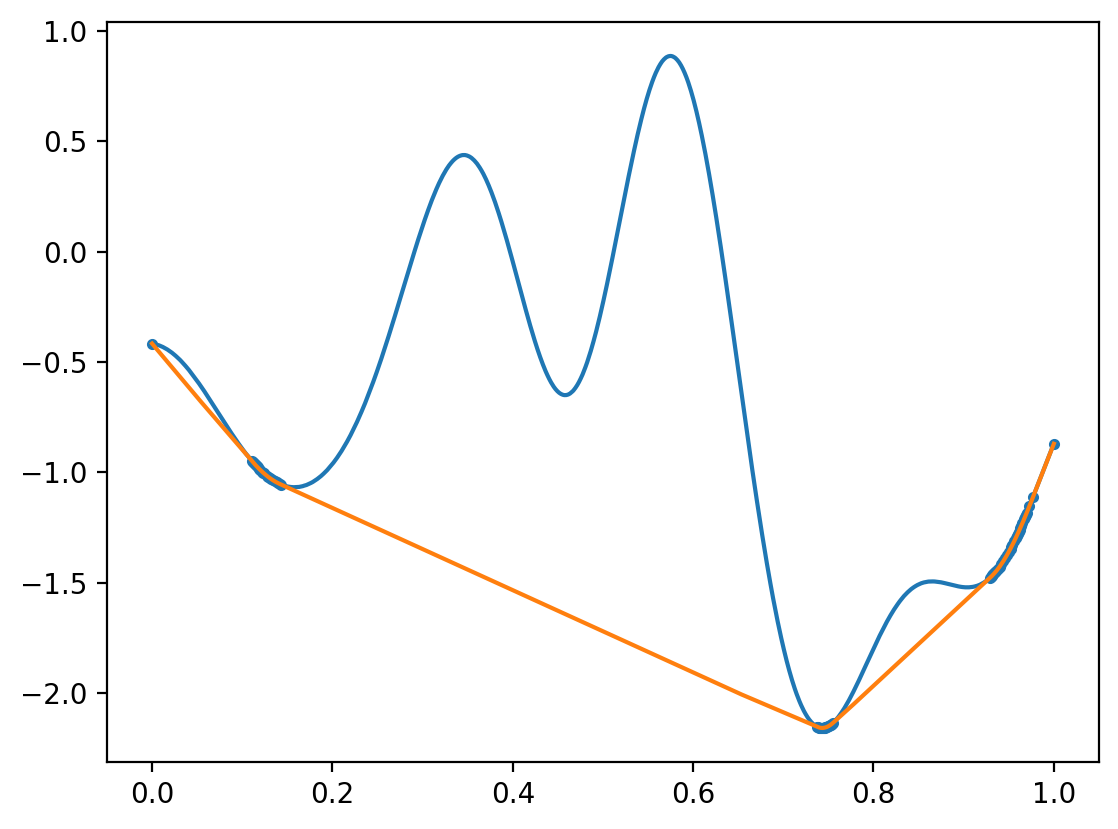

In [18]:
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

#conv1 = convex_envelope(design_space, true_y, tol=0)
#conv2 = convex_envelope(design_space, true_y, tol=0.05)
_, _, conv3 = compute_hull(design_space, true_y)


# this doesn't compute the hull, just the points on the hull
#plt.scatter(design_space[conv1], true_y[conv1])
#plt.scatter(design_space[conv2], true_y[conv2], marker="x")
plt.scatter(design_space[conv3], true_y[conv3], marker=".")

In [19]:
compute_hull(design_space, true_y)[2]

array([  0, 111, 112, 113, 114, 115, 116, 117, 119, 120, 122, 123, 124,
       127, 129, 131, 132, 134, 136, 138, 140, 142, 143, 737, 738, 739,
       740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752,
       753, 754, 928, 929, 930, 931, 932, 933, 934, 935, 937, 939, 941,
       943, 945, 947, 949, 951, 952, 953, 955, 957, 958, 959, 960, 961,
       962, 963, 964, 966, 967, 968, 969, 972, 976, 999], dtype=int32)

# 2D

In [20]:
n_grid = 20

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out points that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

#set seed
seed = 5
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate energies
true_y, true_envelope = generate_true_function(design_space, knot_N)

# compute tight points w.r.t. generated data
tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))

# observations at each vertex and roughly in the middle
train_x = jnp.array([design_space[0], design_space[10], design_space[24], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[10], true_y[24], true_y[-1]])
data = (train_x, train_y); #dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

In [21]:
points = np.column_stack((design_space, true_y))
hull = ConvexHullSciPy(points)

down_facing = hull.equations[:,-2] < 0
np.unique(hull.simplices[down_facing,:].ravel())

array([  0,   1,  12,  16,  17,  19,  20,  21,  55,  56,  73,  89, 165,
       194, 200, 208, 209], dtype=int32)

In [22]:
convex_envelope(design_space, true_y)

array([  0,   1,  12,  16,  17,  19,  20,  21,  55,  56,  73,  89, 165,
       194, 200, 208, 209], dtype=int32)

In [23]:
compute_hull(design_space, true_y)[2]

array([  0,   1,  12,  16,  17,  19,  20,  21,  55,  56,  73,  89, 165,
       194, 200, 208, 209], dtype=int32)

In [25]:
%timeit convex_envelope_fast(design_space, true_y)

123 µs ± 435 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
%timeit convex_envelope(design_space, true_y)

1.74 ms ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%timeit convex_envelope(design_space, true_y, tol=0.005)

48.7 ms ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit compute_hull(design_space, true_y)

289 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
%timeit convelope(design_space, true_y)

2.02 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
convex_envelope_fast(design_space, true_y)

array([  0,   4,  13,  20,  21,  22,  23,  24,  27,  46,  47,  68,  69,
        90, 107, 110, 127, 128, 170, 192, 193, 198, 207, 208, 244, 245,
       269, 270, 290, 291, 294, 295, 296, 297, 298, 299], dtype=int32)

In [27]:
convex_envelope(design_space, true_y)

array([  0,   1,  13,  23, 170, 198, 244, 269, 270, 290, 291, 294, 295,
       296, 297, 298, 299], dtype=int32)

In [28]:
compute_hull(design_space, true_y)[2]

array([  0,   1,  13,  23, 170, 198, 244, 269, 270, 290, 291, 294, 295,
       296, 297, 298, 299], dtype=int32)

## Scratch

In [356]:
tol = 1e-3 
concentrations = design_space
energies = true_y
points = np.column_stack((concentrations, energies))
dimensions = len(points[0]) - 1
hull = ConvexHullSciPy(points, qhull_options='Qs')
structures = hull.vertices

In [357]:
concentrations = points[hull.vertices][:, 0:-1]
if dimensions == 1:
    concentrations = concentrations.ravel()
energies = points[hull.vertices][:, -1]

if dimensions == 1:
    #%time ces = list(zip(*sorted(zip(concentrations, energies, structures))))
    #concentrations = np.array(ces[0])
    #energies = np.array(ces[1])
    #structures = np.array(ces[2])
    inds = concentrations.argsort()
    concentrations = concentrations[inds]
    energies = energies[inds]
    structures = structures[inds]

In [360]:
# Remove points that are above the "pure components plane"
if dimensions == 1:
    vertices = np.array([concentrations.argmin(), concentrations.argmax()])
else:
    concentration_hull = ConvexHullSciPy(concentrations, qhull_options='Qs')
    vertices = concentration_hull.vertices

In [361]:
vertices

array([ 0,  7, 36], dtype=int32)

In [362]:
mask = np.ones(concentrations.shape[0], dtype=bool)
mask[vertices] = False
    
for plane in itertools.combinations(vertices, min(len(vertices), dimensions + 1)):

    plane_concentrations = concentrations[list(plane)]
    plane_energies = energies[list(plane)]

    plane_energy_pure = griddata(plane_concentrations, plane_energies, concentrations[mask], method='linear')
    mask[mask] &= plane_energy_pure >= energies[mask] - tol

# include
mask[vertices] = True

In [365]:
structures[mask]

array([  0,   1,  13,  23, 170, 198, 244, 269, 270, 290, 291, 294, 295,
       296, 297, 298, 299], dtype=int32)